# **single_output_model**


  TRAINING MODEL: BiLSTM
Scaler for BiLSTM saved to 'scaler_BiLSTM.joblib'
Using device: cuda
Starting training for BiLSTM model...
Epoch [10/500], Train Loss: 0.009799, Val Loss: 0.010359
Epoch [20/500], Train Loss: 0.009485, Val Loss: 0.010352
Epoch [30/500], Train Loss: 0.009304, Val Loss: 0.010273
Epoch [40/500], Train Loss: 0.009101, Val Loss: 0.013400
Early stopping triggered at epoch 48.
Best model saved to 'model_BiLSTM.pth'

  TRAINING MODEL: BiGRU
Scaler for BiGRU saved to 'scaler_BiGRU.joblib'
Using device: cuda
Starting training for BiGRU model...
Epoch [10/500], Train Loss: 0.009567, Val Loss: 0.010408
Epoch [20/500], Train Loss: 0.009314, Val Loss: 0.010599
Epoch [30/500], Train Loss: 0.009266, Val Loss: 0.011328
Early stopping triggered at epoch 33.
Best model saved to 'model_BiGRU.pth'

  TRAINING MODEL: Conv1D_LSTM
Scaler for Conv1D_LSTM saved to 'scaler_Conv1D_LSTM.joblib'
Using device: cuda
Starting training for Conv1D_LSTM model...
Epoch [10/500], Train Loss: 0.009

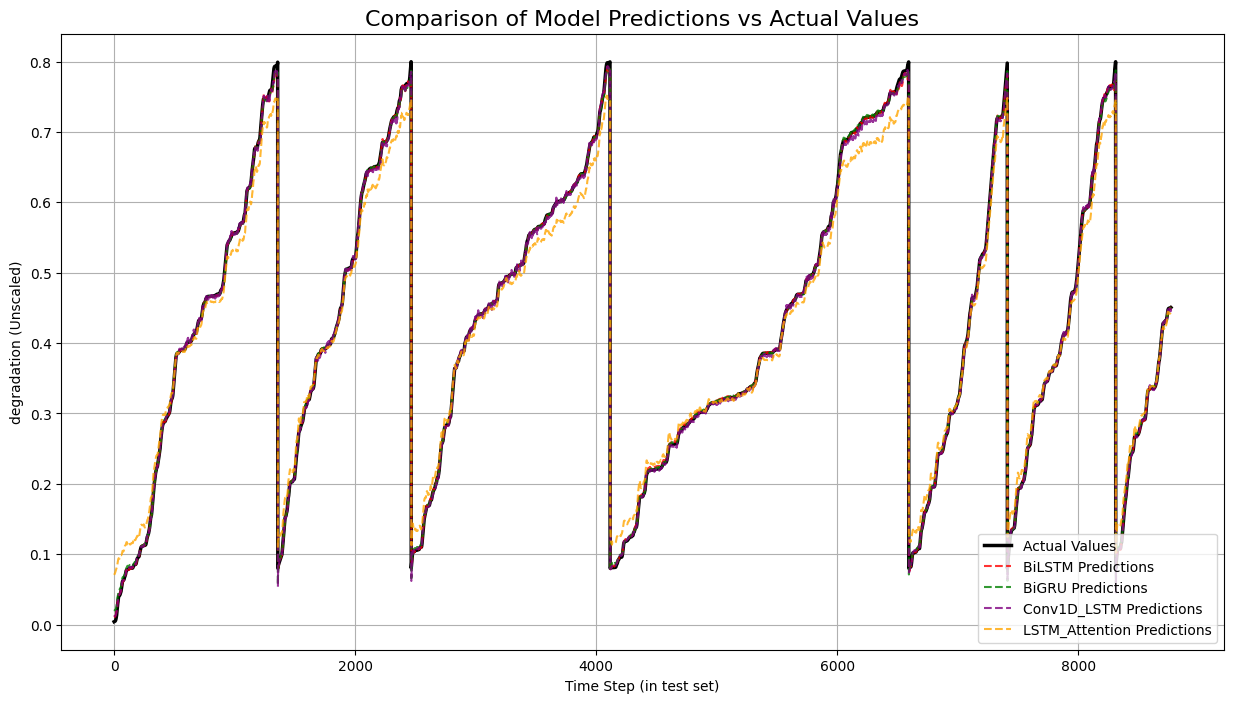

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
import time
import joblib
import sys


CONFIG = {
    "train_data_path": "/content/drive/MyDrive/traindata.csv",
    "test_data_path": "/content/drive/MyDrive/testdata.csv",
    "target_column": "degradation",
    "window_size": 15,
    "hidden_size": 128,
    "num_layers": 2,
    "output_size": 1,
    "dropout": 0.2,
    "conv_filters": 64,
    "kernel_size": 3,
    "learning_rate": 0.0005,
    "weight_decay": 1e-5,
    "batch_size": 16,
    "num_epochs": 500,
    "early_stopping_patience": 10,
    "validation_split": 0.2
}


def create_sequences(data, target_column_index, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size, target_column_index])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx].unsqueeze(-1)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.Ua = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.Va = nn.Linear(hidden_size * 2, 1)
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query.unsqueeze(1)) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_size)
        self.head = nn.Sequential(nn.LayerNorm(hidden_size * 2), nn.Linear(hidden_size * 2, hidden_size), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_size, hidden_size // 2), nn.ReLU(), nn.Linear(hidden_size // 2, output_size))
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        query = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        context, attention_weights = self.attention(query, lstm_out)
        out = self.head(context.squeeze(1))
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

class Conv1DLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, conv_filters, kernel_size):
        super(Conv1DLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_filters, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


def train_model(model, config, train_loader, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = CosineAnnealingLR(optimizer, T_max=config["num_epochs"], eta_min=1e-7)
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    best_val_loss = float('inf')
    patience_counter = 0
  
    model_save_path = f"model_{config['model_type']}.pth"
    print(f"Starting training for {config['model_type']} model...")
    for epoch in range(config["num_epochs"]):
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        scheduler.step()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= config['early_stopping_patience']:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    print(f"Best model saved to '{model_save_path}'")
    return history



if __name__ == "__main__":
    
    dff_train = pd.read_csv(CONFIG["train_data_path"])
    dff_test = pd.read_csv(CONFIG["test_data_path"])
    dff_train_numeric = dff_train.select_dtypes(include=[np.number])
    dff_test_numeric = dff_test.select_dtypes(include=[np.number])

    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dff_train_numeric)

    
    target_col_index = dff_train_numeric.columns.get_loc(CONFIG["target_column"])
    Xt, yt = create_sequences(data_scaled, target_col_index, CONFIG["window_size"])
    split_index = int(len(Xt) * (1 - CONFIG["validation_split"]))
    X_train, X_val = Xt[:split_index], Xt[split_index:]
    y_train, y_val = yt[:split_index], yt[split_index:]
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
    CONFIG["input_size"] = X_train.shape[2]

    
    model_types_to_run = ['BiLSTM', 'BiGRU', 'Conv1D_LSTM', 'LSTM_Attention']
    all_results = {}

    for model_type in model_types_to_run:
        print("\n" + "="*50)
        print(f"  TRAINING MODEL: {model_type}")
        print("="*50)
        CONFIG['model_type'] = model_type

        
        scaler_save_path = f"scaler_{model_type}.joblib"
        joblib.dump(scaler, scaler_save_path)
        print(f"Scaler for {model_type} saved to '{scaler_save_path}'")
        # ===============================================================

        
        if model_type == 'LSTM_Attention':
            model = LSTMAttentionModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"])
        elif model_type == 'BiLSTM':
            model = BiLSTMModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"])
        elif model_type == 'BiGRU':
            model = BiGRUModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"])
        elif model_type == 'Conv1D_LSTM':
            model = Conv1DLSTMModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"], conv_filters=CONFIG['conv_filters'], kernel_size=CONFIG['kernel_size'])

        
        history = train_model(model, CONFIG, train_loader, val_loader)

      
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(f"model_{model_type}.pth", map_location=device))
        model.to(device)
        model.eval()

        test_aligned = dff_test_numeric.reindex(columns=dff_train_numeric.columns, fill_value=0)
        test_scaled = scaler.transform(test_aligned)
        test_target_index = test_aligned.columns.get_loc(CONFIG["target_column"])
        X_test, y_test = create_sequences(test_scaled, test_target_index, CONFIG["window_size"])
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

        with torch.no_grad():
            preds_tensor = model(X_test_tensor.to(device))
        preds_scaled = preds_tensor.cpu().numpy().flatten()
        actuals_scaled = y_test

        preds_full = np.zeros((len(preds_scaled), len(scaler.feature_names_in_)))
        preds_full[:, test_target_index] = preds_scaled
        preds_unscaled = scaler.inverse_transform(preds_full)[:, test_target_index]

        actuals_full = np.zeros((len(actuals_scaled), len(scaler.feature_names_in_)))
        actuals_full[:, test_target_index] = actuals_scaled
        actuals_unscaled = scaler.inverse_transform(actuals_full)[:, test_target_index]

        
        all_results[model_type] = {
            'predictions': preds_unscaled,
            'r2_score': r2_score(actuals_unscaled, preds_unscaled),
            'mse': mean_squared_error(actuals_unscaled, preds_unscaled)
        }

    
    print("\n\n" + "="*50)
    print("  FINAL MODEL COMPARISON")
    print("="*50)

    results_df = pd.DataFrame({
        model: {
            'R2 Score': res['r2_score'],
            'MSE': res['mse']
        } for model, res in all_results.items()
    }).T
    print(results_df.sort_values(by='R2 Score', ascending=False))

   
    print("\nPlotting final comparison of all models...")
    plt.figure(figsize=(15, 8))
    plt.plot(actuals_unscaled, label='Actual Values', color='black', linewidth=2.5)
    colors = ['red', 'green', 'purple', 'orange']
    for i, (model_name, results) in enumerate(all_results.items()):
        plt.plot(results['predictions'], label=f'{model_name} Predictions', linestyle='--', alpha=0.8, color=colors[i])
    plt.title('Comparison of Model Predictions vs Actual Values', fontsize=16)
    plt.xlabel('Time Step (in test set)')
    plt.ylabel(f'{CONFIG["target_column"]} (Unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

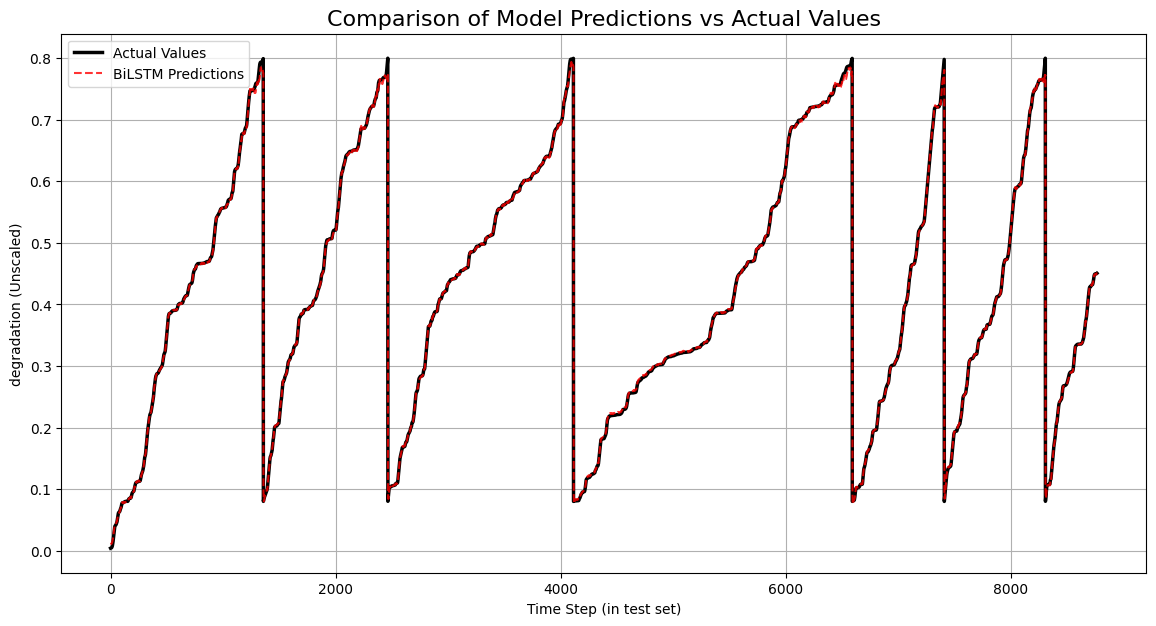

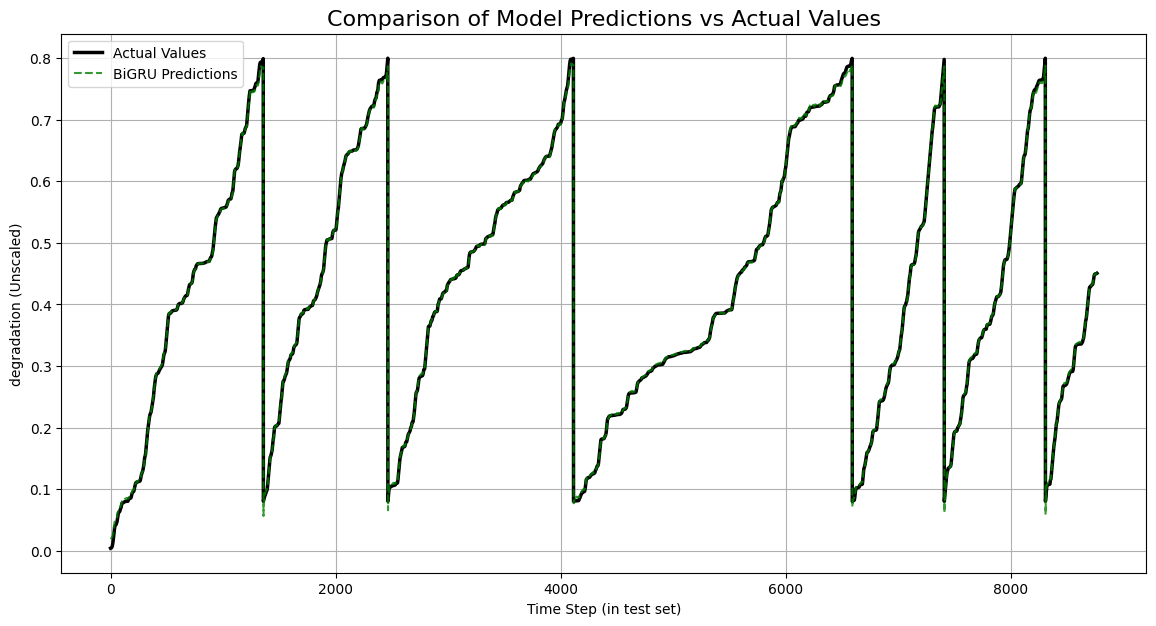

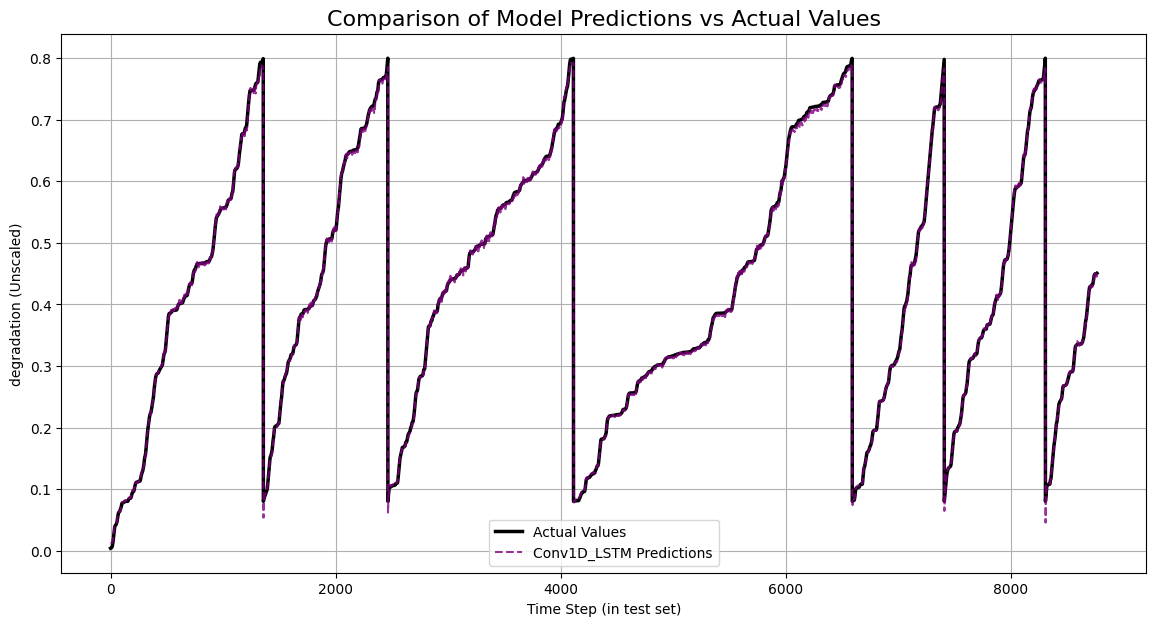

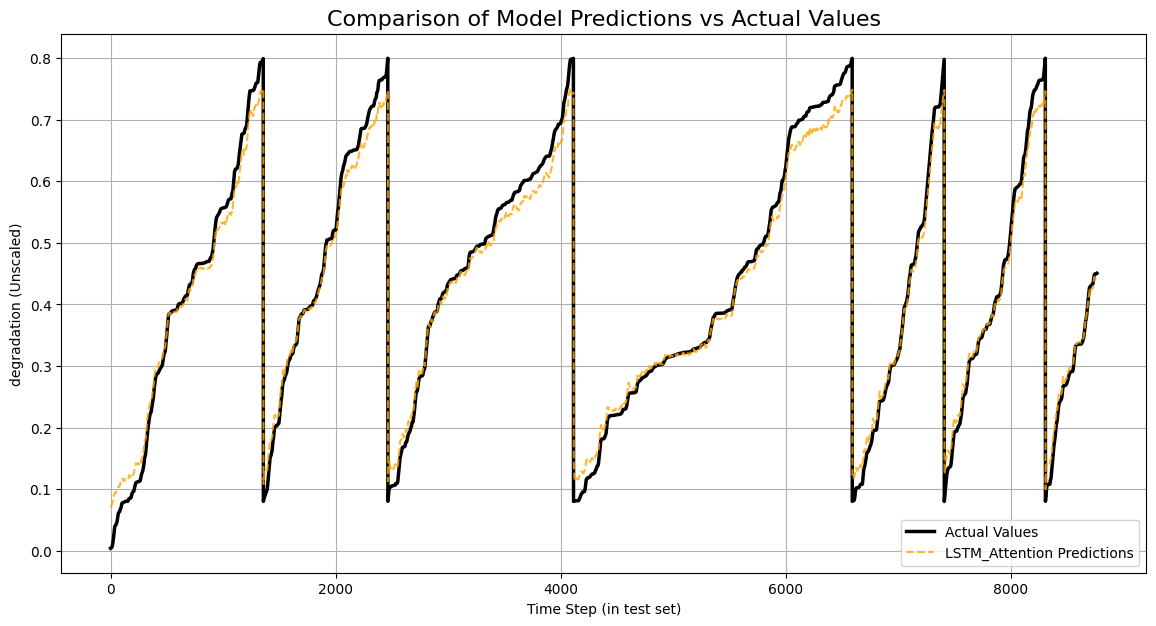

In [ ]:

colors = ['red', 'green', 'purple', 'orange']
for i, (model_name, results) in enumerate(all_results.items()):
    plt.figure(figsize=(14, 7))
    plt.plot(actuals_unscaled, label='Actual Values', color='black', linewidth=2.5)
    plt.plot(results['predictions'], label=f'{model_name} Predictions', linestyle='--', alpha=0.8, color=colors[i])

    plt.title('Comparison of Model Predictions vs Actual Values', fontsize=16)
    plt.xlabel('Time Step (in test set)')
    plt.ylabel(f'{CONFIG["target_column"]} (Unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# **2025_test_data**

Successfully loaded new data from '/content/drive/MyDrive/2025p.csv' with shape (3717, 14)

  PREDICTING WITH MODEL: BiLSTM
Successfully generated 3703 predictions.

  PREDICTING WITH MODEL: BiGRU
Successfully generated 3703 predictions.

  PREDICTING WITH MODEL: Conv1D_LSTM
Successfully generated 3703 predictions.

  PREDICTING WITH MODEL: LSTM_Attention
Successfully generated 3703 predictions.

--- Consolidating all predictions... ---
All predictions saved to 'new_data_with_all_predictions.csv'

Plotting final comparison of all models...


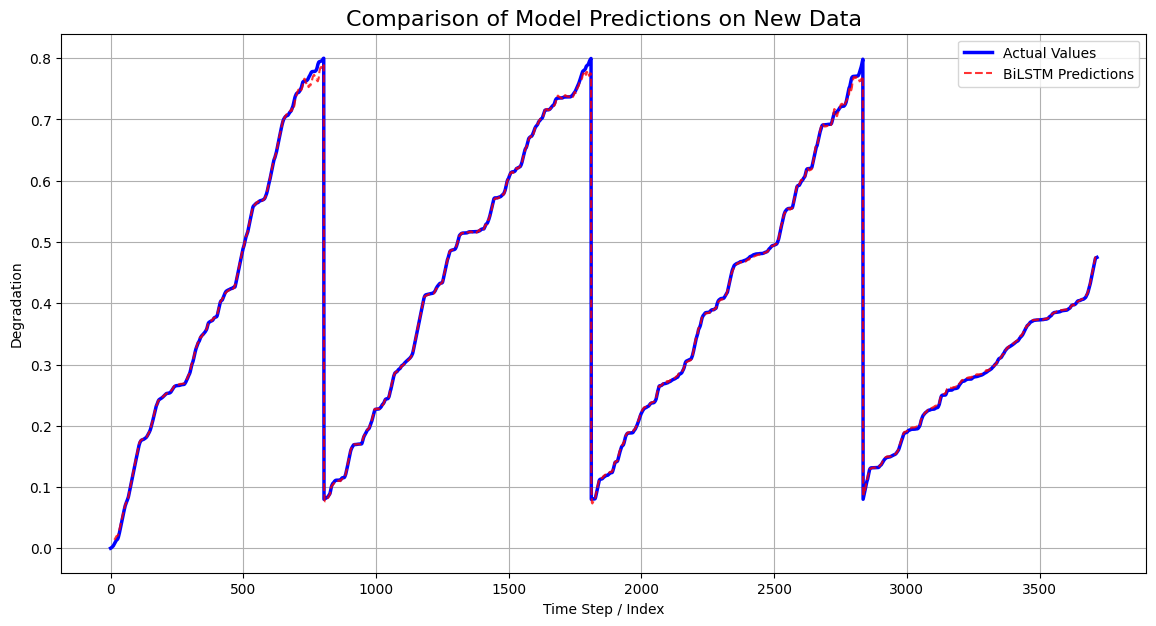

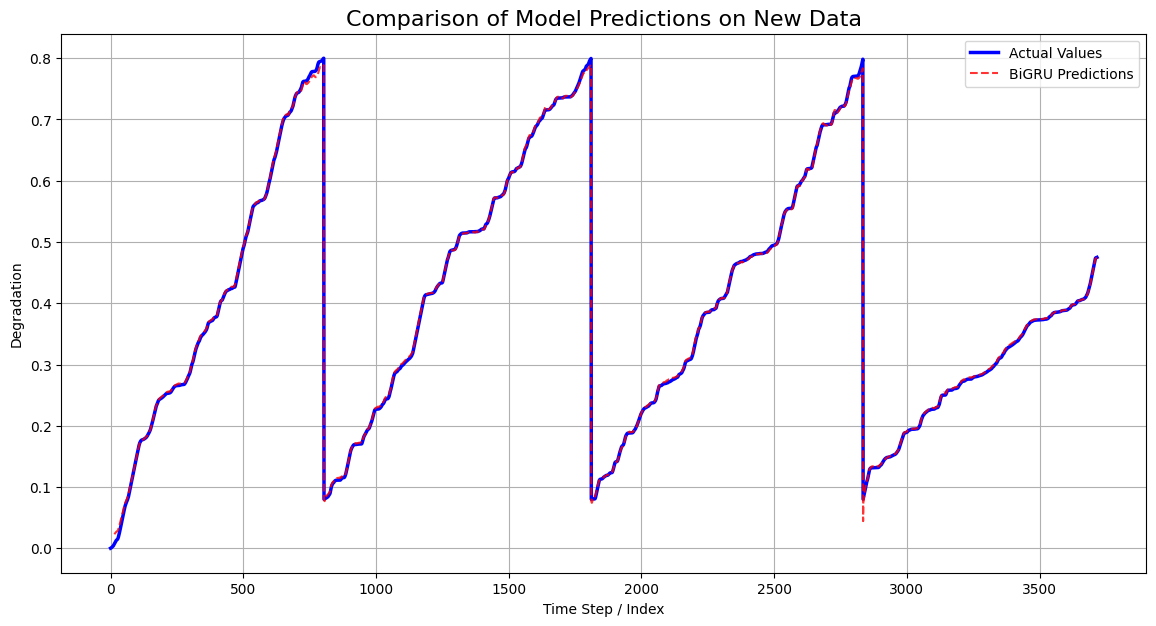

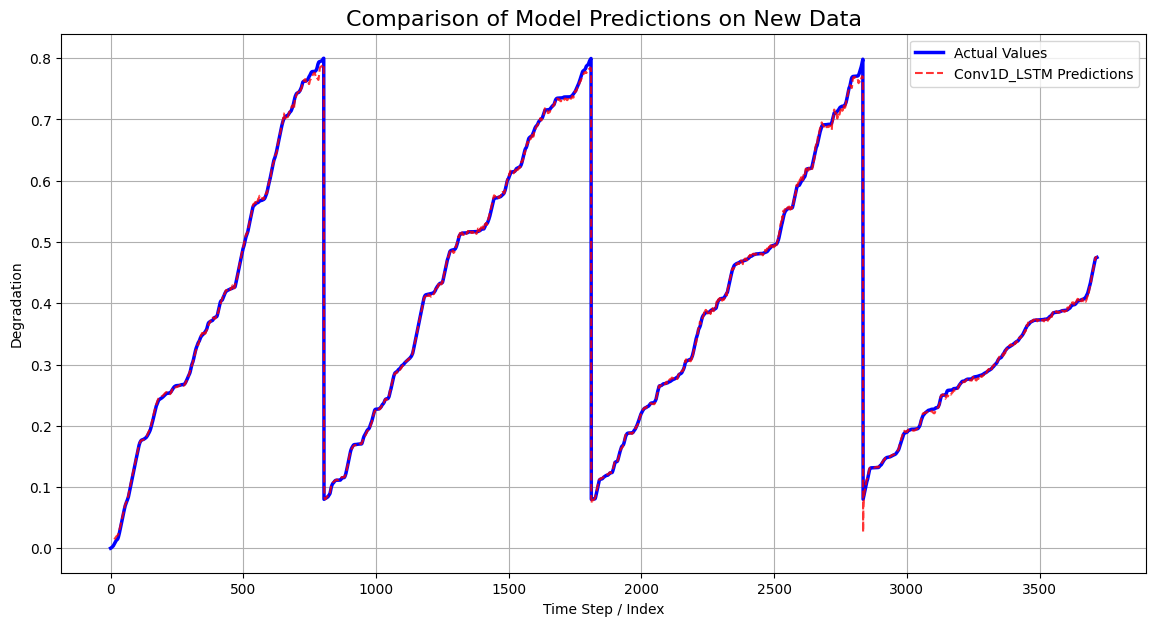

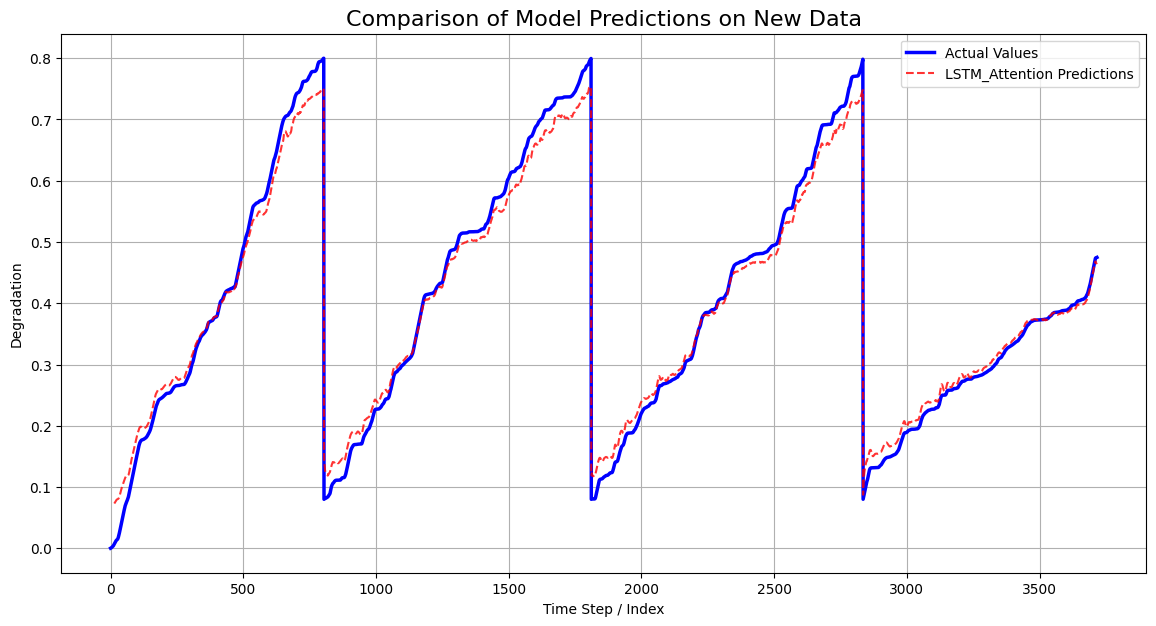

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
import os
import sys
import matplotlib.pyplot as plt


NEW_DATA_PATH = "/content/drive/MyDrive/2025p.csv"
TARGET_COLUMN = "degradation"


MODELS_TO_RUN = ['BiLSTM', 'BiGRU', 'Conv1D_LSTM', 'LSTM_Attention']

WINDOW_SIZE = 15
MODEL_HYPERPARAMS = {
    "hidden_size": 128,
    "num_layers": 2,
    "output_size": 1,
    "dropout": 0.2,
    "conv_filters": 64,
    "kernel_size": 3
}



class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.Ua = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.Va = nn.Linear(hidden_size * 2, 1)
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query.unsqueeze(1)) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_size)
        self.head = nn.Sequential(nn.LayerNorm(hidden_size * 2), nn.Linear(hidden_size * 2, hidden_size), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_size, hidden_size // 2), nn.ReLU(), nn.Linear(hidden_size // 2, output_size))
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        query = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        context, _ = self.attention(query, lstm_out)
        out = self.head(context.squeeze(1))
        return out


class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out


class Conv1DLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, conv_filters, kernel_size):
        super(Conv1DLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_filters, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out



def create_sequences_for_prediction(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:(i + window_size)])
    return np.array(sequences)



if __name__ == "__main__":
    try:
        new_df = pd.read_csv(NEW_DATA_PATH)
        print(f"Successfully loaded new data from '{NEW_DATA_PATH}' with shape {new_df.shape}")
    except FileNotFoundError:
        print(f"Error: New data file not found at '{NEW_DATA_PATH}'.")
        sys.exit()

    all_predictions = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for model_type in MODELS_TO_RUN:
        print("\n" + "="*50)
        print(f"  PREDICTING WITH MODEL: {model_type}")
        print("="*50)

        model_path = f"/content/model_{model_type}.pth"
        scaler_path = f"/content/scaler_{model_type}.joblib"

        try:
            scaler = joblib.load(scaler_path)
            input_size = scaler.n_features_in_

           
            if model_type == 'Conv1D_LSTM':
                model = Conv1DLSTMModel(
                    input_size=input_size,
                    hidden_size=MODEL_HYPERPARAMS["hidden_size"],
                    num_layers=MODEL_HYPERPARAMS["num_layers"],
                    output_size=MODEL_HYPERPARAMS["output_size"],
                    dropout=MODEL_HYPERPARAMS["dropout"],
                    conv_filters=MODEL_HYPERPARAMS["conv_filters"],
                    kernel_size=MODEL_HYPERPARAMS["kernel_size"]
                )
            else: 
                model_class_map = {
                    'LSTM_Attention': LSTMAttentionModel,
                    'BiLSTM': BiLSTMModel,
                    'BiGRU': BiGRUModel
                }
                if model_type in model_class_map:
                    model = model_class_map[model_type](
                        input_size=input_size,
                        hidden_size=MODEL_HYPERPARAMS["hidden_size"],
                        num_layers=MODEL_HYPERPARAMS["num_layers"],
                        output_size=MODEL_HYPERPARAMS["output_size"],
                        dropout=MODEL_HYPERPARAMS["dropout"]
                    )
                else:
                    print(f"Warning: Model type '{model_type}' is unknown. Skipping.")
                    continue

            model.load_state_dict(torch.load(model_path, map_location=device))
            model.to(device)
            model.eval()

           
            new_df_numeric = new_df.select_dtypes(include=[np.number])
            new_df_aligned = new_df_numeric.reindex(columns=scaler.feature_names_in_, fill_value=0)
            new_data_scaled = scaler.transform(new_df_aligned)
            X_new = create_sequences_for_prediction(new_data_scaled, WINDOW_SIZE)

            if len(X_new) == 0:
                print(f"Warning: Not enough data ({len(new_df)} rows) to create a sequence for window size {WINDOW_SIZE}. Skipping model.")
                continue

            
            X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
            with torch.no_grad():
                preds_tensor = model(X_new_tensor)
            preds_scaled = preds_tensor.cpu().numpy().flatten()

            
            target_col_index = list(scaler.feature_names_in_).index(TARGET_COLUMN)
            preds_full_structure = np.zeros((len(preds_scaled), scaler.n_features_in_))
            preds_full_structure[:, target_col_index] = preds_scaled
            final_predictions = scaler.inverse_transform(preds_full_structure)[:, target_col_index]

            all_predictions[model_type] = final_predictions
            print(f"Successfully generated {len(final_predictions)} predictions.")

        except FileNotFoundError:
            print(f"Warning: Artifacts for model '{model_type}' not found (e.g., {model_path}). Skipping.")
        except Exception as e:
            print(f"An error occurred while processing model '{model_type}': {e}")

   
    if all_predictions:
        print("\n--- Consolidating all predictions... ---")
        output_df = new_df.copy()

        for model_name, preds in all_predictions.items():
            start_index = WINDOW_SIZE - 1
            output_df[f'predicted_{model_name}'] = np.nan
            
            pred_len = len(preds)
            df_len = len(output_df)
            if start_index + pred_len > df_len:
                preds = preds[:df_len - start_index]
            output_df.loc[start_index:start_index + len(preds) - 1, f'predicted_{model_name}'] = preds

        output_path = "new_data_with_all_predictions.csv"
        output_df.to_csv(output_path, index=False)
        print(f"All predictions saved to '{output_path}'")

       
        print("\nPlotting final comparison of all models...")


        for model_name, preds in all_predictions.items():
            plt.figure(figsize=(14, 7))
            plt.plot(output_df.index, output_df[TARGET_COLUMN], label='Actual Values', color='blue', linewidth=2.5)
            plt.plot(output_df.index, output_df[f'predicted_{model_name}'], label=f'{model_name} Predictions', color ='red', linestyle='--', alpha=0.8)
            plt.title('Comparison of Model Predictions on New Data', fontsize=16)
            plt.xlabel('Time Step / Index')
            plt.ylabel('Degradation')
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print("\nNo predictions were generated. Please check for errors above.")

# **Multi_output**


  TRAINING MODEL: BiLSTM
Scaler for BiLSTM saved to 'scaler_BiLSTM.joblib'
Using device: cuda
Starting training for BiLSTM model...
Epoch [10/500], Train Loss: 0.042168, Val Loss: 0.040974
Epoch [20/500], Train Loss: 0.041106, Val Loss: 0.039927
Epoch [30/500], Train Loss: 0.040725, Val Loss: 0.039988
Early stopping triggered at epoch 37.
Best model saved to 'model_BiLSTM.pth'

  TRAINING MODEL: BiGRU
Scaler for BiGRU saved to 'scaler_BiGRU.joblib'
Using device: cuda
Starting training for BiGRU model...
Epoch [10/500], Train Loss: 0.042011, Val Loss: 0.040252
Epoch [20/500], Train Loss: 0.041151, Val Loss: 0.039605
Epoch [30/500], Train Loss: 0.040857, Val Loss: 0.040040
Epoch [40/500], Train Loss: 0.040647, Val Loss: 0.039438
Early stopping triggered at epoch 42.
Best model saved to 'model_BiGRU.pth'

  TRAINING MODEL: Conv1D_LSTM
Scaler for Conv1D_LSTM saved to 'scaler_Conv1D_LSTM.joblib'
Using device: cuda
Starting training for Conv1D_LSTM model...
Epoch [10/500], Train Loss: 0.043

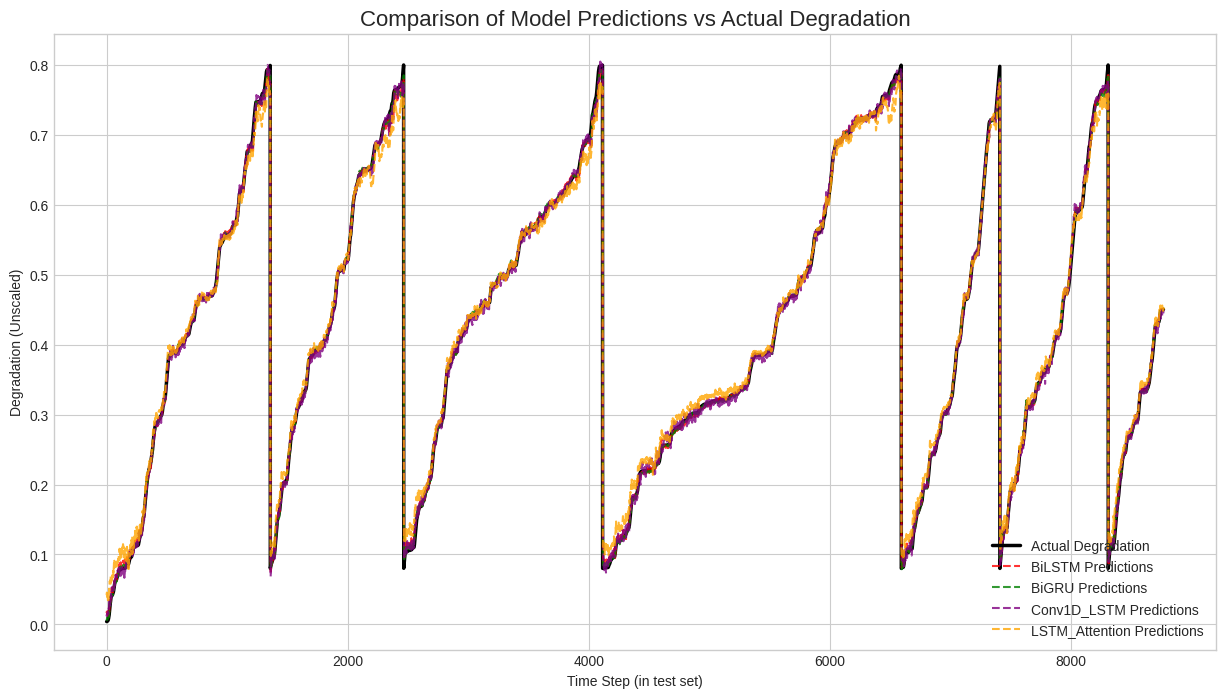

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
import time
import joblib
import sys


CONFIG = {
    "train_data_path": "/content/drive/MyDrive/traindata.csv",
    "test_data_path": "/content/drive/MyDrive/testdata.csv",
    "target_columns": ["degradation", "temperature_estimated", "system_torque_knm"],
    "window_size": 15,
    "hidden_size": 64,     
    "num_layers": 1,        
    "output_size": 3,
    "dropout": 0.4,        
    "conv_filters": 32,     
    "kernel_size": 3,
    "learning_rate": 0.0005,
    "weight_decay": 1e-4,  
    "batch_size": 32,       
    "num_epochs": 500,
    "early_stopping_patience": 15, 
    "validation_split": 0.2
}
CONFIG["output_size"] = len(CONFIG["target_columns"])


def create_multi_output_sequences(data, target_indices, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size, target_indices])
    return np.array(X), np.array(y)

class MultiOutputTimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__(); self.Wa = nn.Linear(hidden_size * 2, hidden_size * 2); self.Ua = nn.Linear(hidden_size * 2, hidden_size * 2); self.Va = nn.Linear(hidden_size * 2, 1)
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query.unsqueeze(1)) + self.Ua(keys))); scores = scores.squeeze(2).unsqueeze(1); weights = F.softmax(scores, dim=-1); context = torch.bmm(weights, keys); return context, weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMAttentionModel, self).__init__(); self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0); self.attention = Attention(hidden_size)
        self.head = nn.Sequential(nn.LayerNorm(hidden_size * 2), nn.Linear(hidden_size * 2, hidden_size), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_size, output_size))
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x); query = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1); context, _ = self.attention(query, lstm_out); out = self.head(context.squeeze(1)); return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__(); self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x); out = self.fc(lstm_out[:, -1, :]); return out

class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiGRUModel, self).__init__(); self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        gru_out, _ = self.gru(x); out = self.fc(gru_out[:, -1, :]); return out

class Conv1DLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, conv_filters, kernel_size):
        super(Conv1DLSTMModel, self).__init__(); self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size, padding='same'); self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_filters, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=dropout if num_layers > 1 else 0); self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1); x = self.conv1d(x); x = self.relu(x); x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x); out = self.fc(lstm_out[:, -1, :]); return out

# --- 4. Training Function ---
def train_model(model, config, train_loader, val_loader):
    # This function is correct and does not need changes
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"Using device: {device}"); model.to(device)
    criterion = nn.MSELoss(); optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = CosineAnnealingLR(optimizer, T_max=config["num_epochs"], eta_min=1e-7)
    history = {'train_loss': [], 'val_loss': []}; best_val_loss = float('inf'); patience_counter = 0
    model_save_path = f"model_{config['model_type']}.pth"; print(f"Starting training for {config['model_type']} model...")
    for epoch in range(config["num_epochs"]):
        model.train(); total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device); outputs = model(batch_X); loss = criterion(outputs, batch_y)
            optimizer.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0); optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        model.eval(); total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device); outputs = model(batch_X); loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        if (epoch + 1) % 10 == 0: print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        scheduler.step()
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss; torch.save(model.state_dict(), model_save_path); patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= config['early_stopping_patience']: print(f"Early stopping triggered at epoch {epoch+1}."); break
    print(f"Best model saved to '{model_save_path}'"); return history


if __name__ == "__main__":
    
    dff_train = pd.read_csv(CONFIG["train_data_path"])
    dff_test = pd.read_csv(CONFIG["test_data_path"])
    dff_train_numeric = dff_train.select_dtypes(include=[np.number])
    dff_test_numeric = dff_test.select_dtypes(include=[np.number])

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dff_train_numeric)

    target_indices = [dff_train_numeric.columns.get_loc(col) for col in CONFIG["target_columns"]]

    
    test_aligned = dff_test_numeric.reindex(columns=dff_train_numeric.columns, fill_value=0)
    test_scaled = scaler.transform(test_aligned)
    X_test_sequences, y_test_sequences = create_multi_output_sequences(test_scaled, target_indices, CONFIG["window_size"])

    
    Xt, yt = create_multi_output_sequences(data_scaled, target_indices, CONFIG["window_size"])
    split_index = int(len(Xt) * (1 - CONFIG["validation_split"]))
    X_train, X_val = Xt[:split_index], Xt[split_index:]
    y_train, y_val = yt[:split_index], yt[split_index:]
    train_dataset = MultiOutputTimeSeriesDataset(X_train, y_train)
    val_dataset = MultiOutputTimeSeriesDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
    CONFIG["input_size"] = X_train.shape[2]

   
    model_types_to_run = ['BiLSTM', 'BiGRU', 'Conv1D_LSTM', 'LSTM_Attention']
    all_results = {}
    num_features = scaler.n_features_in_
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for model_type in model_types_to_run:
        print("\n" + "="*50); print(f"  TRAINING MODEL: {model_type}"); print("="*50)
        CONFIG['model_type'] = model_type

        scaler_save_path = f"scaler_{model_type}.joblib"
        joblib.dump( scaler, scaler_save_path)
        print(f"Scaler for {model_type} saved to '{scaler_save_path}'")

        model_class_map = {'LSTM_Attention': LSTMAttentionModel, 'BiLSTM': BiLSTMModel, 'BiGRU': BiGRUModel, 'Conv1D_LSTM': Conv1DLSTMModel}
        if model_type in model_class_map:
            params = {"input_size": CONFIG["input_size"], "hidden_size": CONFIG["hidden_size"], "num_layers": CONFIG["num_layers"], "output_size": CONFIG["output_size"], "dropout": CONFIG["dropout"]}
            if model_type == 'Conv1D_LSTM': params.update({"conv_filters": CONFIG['conv_filters'], "kernel_size": CONFIG['kernel_size']})
            model = model_class_map[model_type](**params)
        else: print(f"Error: Unknown model_type '{model_type}'."); continue

        history = train_model(model, CONFIG, train_loader, val_loader)

        
        model.load_state_dict(torch.load(f"model_{model_type}.pth", map_location=device)); model.to(device); model.eval()
        X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)

        with torch.no_grad(): preds_tensor = model(X_test_tensor.to(device))
        preds_scaled = preds_tensor.cpu().numpy()

        preds_full_structure = np.zeros((len(preds_scaled), num_features))
        np.put_along_axis(preds_full_structure, np.array(target_indices)[np.newaxis, :], preds_scaled, axis=1)
        preds_unscaled_full = scaler.inverse_transform(preds_full_structure)

        preds_unscaled_targets = preds_unscaled_full[:, target_indices]
        all_results[model_type] = {'predictions': pd.DataFrame(preds_unscaled_targets, columns=CONFIG["target_columns"])}

    
    actuals_full_structure = np.zeros((len(y_test_sequences), num_features))
    np.put_along_axis(actuals_full_structure, np.array(target_indices)[np.newaxis, :], y_test_sequences, axis=1)
    actuals_unscaled_full = scaler.inverse_transform(actuals_full_structure)


    actuals_unscaled_targets = actuals_unscaled_full[:, target_indices]
    all_results['actuals'] = pd.DataFrame(actuals_unscaled_targets, columns=CONFIG["target_columns"])
    # ===================================================================

    RESULTS_FILE_PATH = "all_model_results.joblib"
    joblib.dump(all_results, RESULTS_FILE_PATH)
    print(f"\nAll predictions and actuals saved to '{RESULTS_FILE_PATH}'")

    
    print("\n\n" + "="*50); print("  FINAL MODEL COMPARISON (on 'degradation')"); print("="*50)
    metrics_summary = {}
    for model_name, results in all_results.items():
        if model_name == 'actuals': continue
        actuals = all_results['actuals']['degradation']
        preds = results['predictions']['degradation']
        metrics_summary[model_name] = {'R2 Score': r2_score(actuals, preds), 'MSE': mean_squared_error(actuals, preds)}

    results_df = pd.DataFrame(metrics_summary).T
    print(results_df.sort_values(by='R2 Score', ascending=False))

    print("\nPlotting final comparison of all models...")
    plt.figure(figsize=(15, 8))
    plt.plot(all_results['actuals']['degradation'].values, label='Actual Degradation', color='black', linewidth=2.5)
    colors = ['red', 'green', 'purple', 'orange']
    for i, (model_name, results) in enumerate(all_results.items()):
        if model_name != 'actuals':
            plt.plot(results['predictions']['degradation'].values, label=f'{model_name} Predictions', linestyle='--', alpha=0.8, color=colors[i])
    plt.title('Comparison of Model Predictions vs Actual Degradation', fontsize=16)
    plt.xlabel('Time Step (in test set)')
    plt.ylabel('Degradation (Unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

Loading results from 'all_model_results.joblib'...

Best overall model (based on 'degradation' R² score) is: BiGRU

--- Evaluating BiGRU's performance on 'temperature_estimated' ---
  R-squared (R²) for temperature_estimated: 0.9219
  Mean Absolute Error (MAE) for temperature_estimated: 1.6856

Plotting predictions for 'temperature_estimated'...


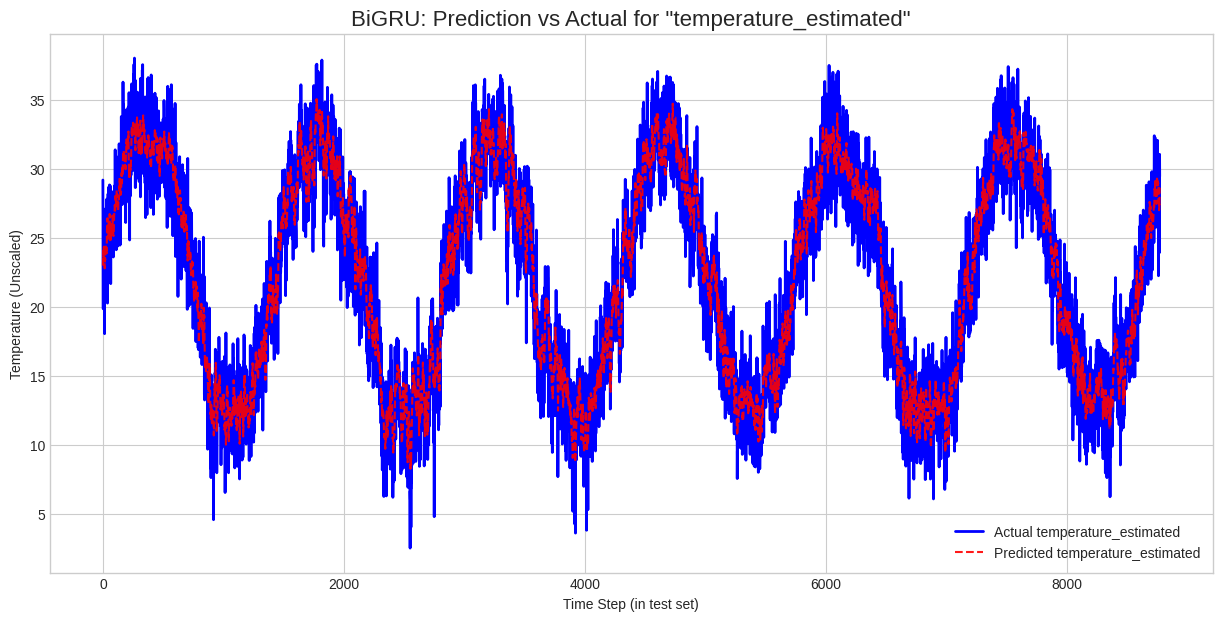

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import r2_score, mean_absolute_error


RESULTS_FILE_PATH = "all_model_results.joblib"
PRIMARY_TARGET = "degradation"
TARGET_TO_PLOT = "temperature_estimated" 


if __name__ == "__main__":
    print(f"Loading results from '{RESULTS_FILE_PATH}'...")
    try:
        all_results = joblib.load(RESULTS_FILE_PATH)
    except FileNotFoundError:
        print(f"Error: Results file not found at '{RESULTS_FILE_PATH}'.")
        print("Please run the main training script first to generate the results file.")
        sys.exit()

    
    metrics_summary = {}
    for model_name, results in all_results.items():
        if model_name == 'actuals': continue
        actuals_primary = all_results['actuals'][PRIMARY_TARGET]
        preds_primary = results['predictions'][PRIMARY_TARGET]
        metrics_summary[model_name] = {'R2 Score': r2_score(actuals_primary, preds_primary)}

    results_df = pd.DataFrame(metrics_summary).T
    best_model_name = results_df.sort_values(by='R2 Score', ascending=False).index[0]
    print(f"\nBest overall model (based on '{PRIMARY_TARGET}' R² score) is: {best_model_name}")

    
    print(f"\n--- Evaluating {best_model_name}'s performance on '{TARGET_TO_PLOT}' ---")

    
    actuals_temp = all_results['actuals'][TARGET_TO_PLOT]
    preds_temp = all_results[best_model_name]['predictions'][TARGET_TO_PLOT]

   
    r2_temp = r2_score(actuals_temp, preds_temp)
    mae_temp = mean_absolute_error(actuals_temp, preds_temp)

    print(f"  R-squared (R²) for {TARGET_TO_PLOT}: {r2_temp:.4f}")
    print(f"  Mean Absolute Error (MAE) for {TARGET_TO_PLOT}: {mae_temp:.4f}")

  
    print(f"\nPlotting predictions for '{TARGET_TO_PLOT}'...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))

   
    plt.plot(actuals_temp.index, actuals_temp, label=f'Actual {TARGET_TO_PLOT}', color='blue', linewidth=2)

    
    plt.plot(preds_temp.index, preds_temp, label=f'Predicted {TARGET_TO_PLOT}', color='red', linestyle='--', alpha=0.9)

    plt.title(f'{best_model_name}: Prediction vs Actual for "{TARGET_TO_PLOT}"', fontsize=16)
    plt.xlabel('Time Step (in test set)')
    plt.ylabel('Temperature (Unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

Loading results from 'all_model_results.joblib'...

Best overall model (based on 'degradation' R² score) is: BiGRU

--- Evaluating BiGRU's performance on 'system_torque_knm' ---
  R-squared (R²) for system_torque_knm: 0.9653
  Mean Absolute Error (MAE) for system_torque_knm: 39.4063

Plotting predictions for 'system_torque_knm'...


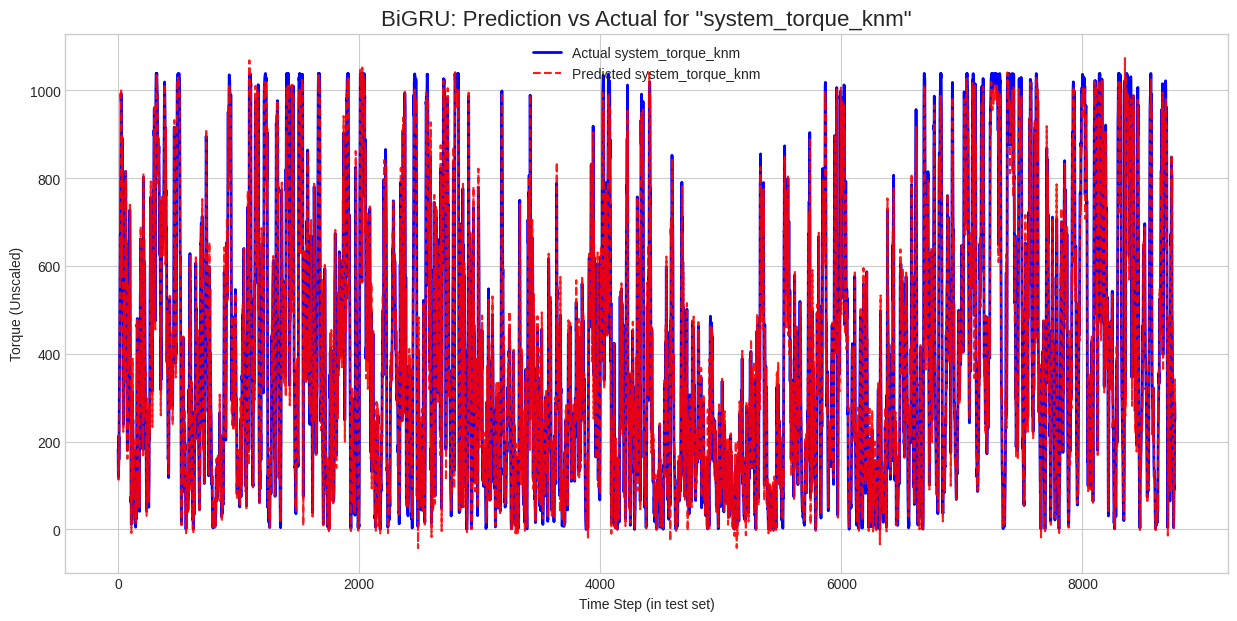

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import r2_score, mean_absolute_error


RESULTS_FILE_PATH = "all_model_results.joblib"
PRIMARY_TARGET = "degradation"
TARGET_TO_PLOT = "system_torque_knm" 


if __name__ == "__main__":
    print(f"Loading results from '{RESULTS_FILE_PATH}'...")
    try:
        all_results = joblib.load(RESULTS_FILE_PATH)
    except FileNotFoundError:
        print(f"Error: Results file not found at '{RESULTS_FILE_PATH}'.")
        print("Please run the main training script first to generate the results file.")
        sys.exit()

    
    metrics_summary = {}
    for model_name, results in all_results.items():
        if model_name == 'actuals': continue
        actuals_primary = all_results['actuals'][PRIMARY_TARGET]
        preds_primary = results['predictions'][PRIMARY_TARGET]
        metrics_summary[model_name] = {'R2 Score': r2_score(actuals_primary, preds_primary)}

    results_df = pd.DataFrame(metrics_summary).T
    best_model_name = results_df.sort_values(by='R2 Score', ascending=False).index[0]
    print(f"\nBest overall model (based on '{PRIMARY_TARGET}' R² score) is: {best_model_name}")

    
    print(f"\n--- Evaluating {best_model_name}'s performance on '{TARGET_TO_PLOT}' ---")

   
    actuals_torque = all_results['actuals'][TARGET_TO_PLOT]
    preds_torque = all_results[best_model_name]['predictions'][TARGET_TO_PLOT]

   
    r2_torque = r2_score(actuals_torque, preds_torque)
    mae_torque = mean_absolute_error(actuals_torque, preds_torque)

    print(f"  R-squared (R²) for {TARGET_TO_PLOT}: {r2_torque:.4f}")
    print(f"  Mean Absolute Error (MAE) for {TARGET_TO_PLOT}: {mae_torque:.4f}")

    
    print(f"\nPlotting predictions for '{TARGET_TO_PLOT}'...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))

   
    plt.plot(actuals_torque.index, actuals_torque, label=f'Actual {TARGET_TO_PLOT}', color='blue', linewidth=2)

    
    plt.plot(preds_torque.index, preds_torque, label=f'Predicted {TARGET_TO_PLOT}', color='red', linestyle='--', alpha=0.9)

    plt.title(f'{best_model_name}: Prediction vs Actual for "{TARGET_TO_PLOT}"', fontsize=16)
    plt.xlabel('Time Step (in test set)')
    plt.ylabel('Torque (Unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# **2025 predicted torque**

--- Running Prediction for 'degradation' using Conv1D_LSTM model ---
Loading model '/content/model_Conv1D_LSTM.pth' and scaler '/content/scaler_Conv1D_LSTM.joblib'...
Successfully loaded model '/content/model_Conv1D_LSTM.pth' and scaler '/content/scaler_Conv1D_LSTM.joblib'.
Successfully loaded and preprocessed new data from '/content/drive/MyDrive/2025p.csv'.
Making predictions...

Plotting results...


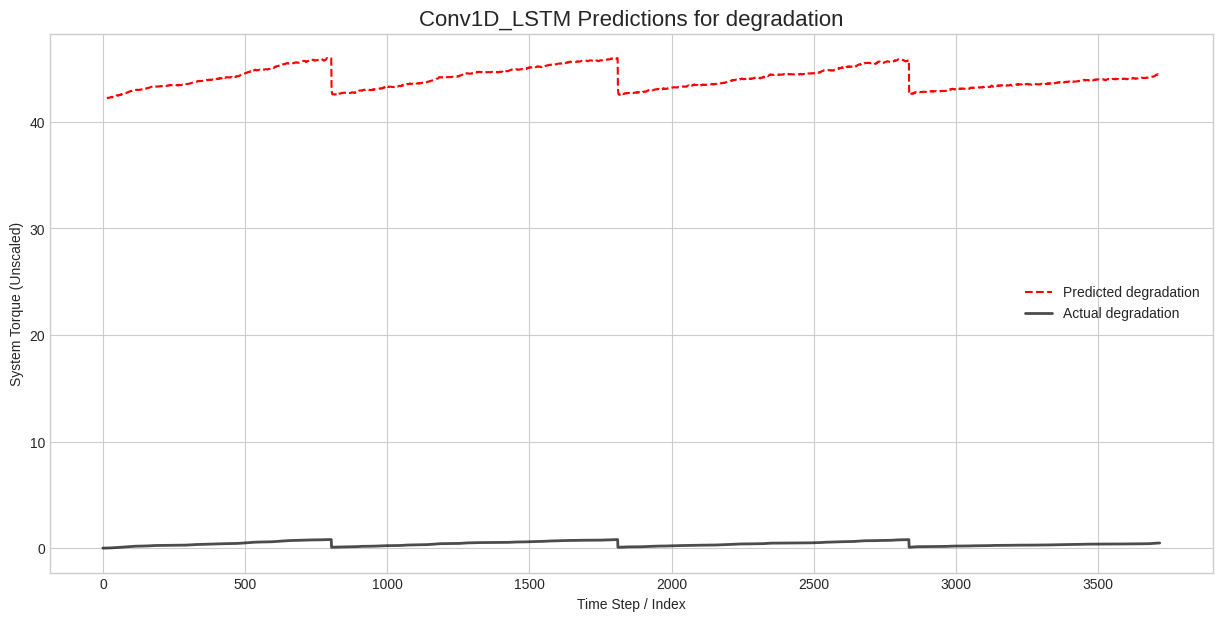

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
import os
import sys
import matplotlib.pyplot as plt

NEW_DATA_PATH = "/content/drive/MyDrive/2025p.csv"  
MODEL_TO_USE = "Conv1D_LSTM"                     


TARGET_COLUMNS = ["degradation", "temperature_estimated", "system_torque_knm"]
TARGET_TO_PLOT = "degradation"
WINDOW_SIZE = 15

MODEL_HYPERPARAMS = {
    "hidden_size": 64,    
    "num_layers": 1,      
    "output_size": len(TARGET_COLUMNS),
    "dropout": 0.4,         
    "conv_filters": 32,     
    "kernel_size": 3,
}


MODEL_PATH = f"/content/model_{MODEL_TO_USE}.pth"
SCALER_PATH = f"/content/scaler_{MODEL_TO_USE}.joblib"



class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__(); self.Wa = nn.Linear(hidden_size * 2, hidden_size * 2); self.Ua = nn.Linear(hidden_size * 2, hidden_size * 2); self.Va = nn.Linear(hidden_size * 2, 1)
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query.unsqueeze(1)) + self.Ua(keys))); scores = scores.squeeze(2).unsqueeze(1); weights = F.softmax(scores, dim=-1); context = torch.bmm(weights, keys); return context, weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMAttentionModel, self).__init__(); self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0); self.attention = Attention(hidden_size)
        self.head = nn.Sequential(nn.LayerNorm(hidden_size * 2), nn.Linear(hidden_size * 2, hidden_size), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_size, output_size))
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x); query = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1); context, _ = self.attention(query, lstm_out); out = self.head(context.squeeze(1)); return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__(); self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x); out = self.fc(lstm_out[:, -1, :]); return out

class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiGRUModel, self).__init__(); self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        gru_out, _ = self.gru(x); out = self.fc(gru_out[:, -1, :]); return out

class Conv1DLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, conv_filters, kernel_size):
        super(Conv1DLSTMModel, self).__init__(); self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size, padding='same'); self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_filters, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=dropout if num_layers > 1 else 0); self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1); x = self.conv1d(x); x = self.relu(x); x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x); out = self.fc(lstm_out[:, -1, :]); return out



def create_sequences_for_prediction(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:(i + window_size)])
    return np.array(sequences)



if __name__ == "__main__":
    print(f"--- Running Prediction for '{TARGET_TO_PLOT}' using {MODEL_TO_USE} model ---")

    try:
        
        print(f"Loading model '{MODEL_PATH}' and scaler '{SCALER_PATH}'...")
        scaler = joblib.load(SCALER_PATH)
        input_size = scaler.n_features_in_


        model_class_map = {'LSTM_Attention': LSTMAttentionModel, 'BiLSTM': BiLSTMModel, 'BiGRU': BiGRUModel, 'Conv1D_LSTM': Conv1DLSTMModel}

        if MODEL_TO_USE in model_class_map:
           
            params = {
                "input_size": input_size,
                "hidden_size": MODEL_HYPERPARAMS["hidden_size"],
                "num_layers": MODEL_HYPERPARAMS["num_layers"],
                "output_size": MODEL_HYPERPARAMS["output_size"],
                "dropout": MODEL_HYPERPARAMS["dropout"]
            }
            
            if MODEL_TO_USE == 'Conv1D_LSTM':
                params["conv_filters"] = MODEL_HYPERPARAMS["conv_filters"]
                params["kernel_size"] = MODEL_HYPERPARAMS["kernel_size"]

            
            model = model_class_map[MODEL_TO_USE](**params)
        else:
            raise ValueError(f"Model type '{MODEL_TO_USE}' is not defined in this script.")
        

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.to(device)
        model.eval()
        print(f"Successfully loaded model '{MODEL_PATH}' and scaler '{SCALER_PATH}'.")

    except FileNotFoundError:
        print(f"\nERROR: Could not find required files.")
        print(f"Please ensure '{MODEL_PATH}' and '{SCALER_PATH}' are in the same directory.")
        sys.exit()
    except Exception as e:
        print(f"\nAn error occurred while loading the model artifacts: {e}")
        sys.exit()

    
    try:
        new_df = pd.read_csv(NEW_DATA_PATH)
        if len(new_df) < WINDOW_SIZE:
             raise ValueError(f"Not enough data to create a sequence. Need at least {WINDOW_SIZE} rows.")

        new_df_numeric = new_df.select_dtypes(include=[np.number])
        new_df_aligned = new_df_numeric.reindex(columns=scaler.feature_names_in_, fill_value=0)
        new_data_scaled = scaler.transform(new_df_aligned)
        X_new = create_sequences_for_prediction(new_data_scaled, WINDOW_SIZE)
        print(f"Successfully loaded and preprocessed new data from '{NEW_DATA_PATH}'.")
    except Exception as e:
        print(f"\nAn error occurred during data preprocessing: {e}")
        sys.exit()

   
    print("Making predictions...")
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds_tensor = model(X_new_tensor)
    preds_scaled = preds_tensor.cpu().numpy()

   
    preds_full_structure = np.zeros((len(preds_scaled), scaler.n_features_in_))
    np.put_along_axis(preds_full_structure, np.array([TARGET_COLUMNS.index(t) for t in TARGET_COLUMNS])[np.newaxis, :], preds_scaled, axis=1)
    preds_unscaled_full = scaler.inverse_transform(preds_full_structure)

    target_col_index = TARGET_COLUMNS.index(TARGET_TO_PLOT)
    final_predictions = preds_unscaled_full[:, target_col_index]

    
    prediction_start_index = WINDOW_SIZE - 1
    new_df[f'predicted_{TARGET_TO_PLOT}'] = np.nan
    new_df.loc[prediction_start_index:prediction_start_index + len(final_predictions) - 1, f'predicted_{TARGET_TO_PLOT}'] = final_predictions

    print("\nPlotting results...")
    plt.figure(figsize=(15, 7))
    plt.plot(new_df.index, new_df[f'predicted_{TARGET_TO_PLOT}'], label=f'Predicted {TARGET_TO_PLOT}', color='red', linestyle='--')
    if TARGET_TO_PLOT in new_df.columns:
        plt.plot(new_df.index, new_df[TARGET_TO_PLOT], label=f'Actual {TARGET_TO_PLOT}', color='black', linewidth=2, alpha=0.7)
    plt.title(f'{MODEL_TO_USE} Predictions for {TARGET_TO_PLOT}', fontsize=16)
    plt.xlabel('Time Step / Index')
    plt.ylabel('System Torque (Unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# **Final try**

# **PLEASE FINAL ONE**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
import joblib


CONFIG = {
    "train_data_path": "/content/drive/MyDrive/traindata.csv",
    "test_data_path": "/content/drive/MyDrive/testdata.csv",
    "target_columns": ["degradation", "temperature_estimated"], 
    "window_size": 15,
    "hidden_size": 128,
    "num_layers": 2,
    "output_size": 2, 
    "dropout": 0.2,
    "conv_filters": 64,
    "kernel_size": 3,
    "learning_rate": 0.0005,
    "weight_decay": 1e-5,
    "batch_size": 16,
    "num_epochs": 500,
    "early_stopping_patience": 10,
    "validation_split": 0.2
}


def create_sequences(data, target_column_indices, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size, target_column_indices])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.Ua = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.Va = nn.Linear(hidden_size * 2, 1)
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query.unsqueeze(1)) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_size)
        self.head = nn.Sequential(nn.LayerNorm(hidden_size * 2), nn.Linear(hidden_size * 2, hidden_size), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_size, hidden_size // 2), nn.ReLU(), nn.Linear(hidden_size // 2, output_size))
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        query = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        context, attention_weights = self.attention(query, lstm_out)
        out = self.head(context.squeeze(1))
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

class Conv1DLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, conv_filters, kernel_size):
        super(Conv1DLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_filters, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


def train_model(model, config, train_loader, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = CosineAnnealingLR(optimizer, T_max=config["num_epochs"], eta_min=1e-7)
    best_val_loss = float('inf')
    patience_counter = 0
    model_save_path = f"model_{config['model_type']}.pth"
    print(f"Starting training for {config['model_type']} model...")
    for epoch in range(config["num_epochs"]):
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        scheduler.step()
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= config['early_stopping_patience']:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
    print(f"Best model for {config['model_type']} saved to '{model_save_path}'")


def main():
    dff_train = pd.read_csv(CONFIG["train_data_path"])
    dff_test = pd.read_csv(CONFIG["test_data_path"])
    dff_train_numeric = dff_train.select_dtypes(include=[np.number])
    dff_test_numeric = dff_test.select_dtypes(include=[np.number])

    
    for col in CONFIG["target_columns"]:
        if col not in dff_train_numeric.columns:
            print(f"FATAL: Target column '{col}' not found in the training data.")
            return None, None, None

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dff_train_numeric)
    joblib.dump(scaler, "main_scaler.joblib")
    print("Main scaler saved to 'main_scaler.joblib'")

    target_col_indices = [dff_train_numeric.columns.get_loc(c) for c in CONFIG["target_columns"]]
    Xt, yt = create_sequences(data_scaled, target_col_indices, CONFIG["window_size"])
    split_index = int(len(Xt) * (1 - CONFIG["validation_split"]))
    X_train, X_val = Xt[:split_index], Xt[split_index:]
    y_train, y_val = yt[:split_index], yt[split_index:]
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
    CONFIG["input_size"] = X_train.shape[2]

    model_types_to_run = ['BiLSTM', 'BiGRU', 'Conv1D_LSTM', 'LSTM_Attention']
    all_results = {}

    test_aligned = dff_test_numeric.reindex(columns=dff_train_numeric.columns, fill_value=0)
    test_scaled = scaler.transform(test_aligned)
    test_target_indices = [test_aligned.columns.get_loc(c) for c in CONFIG["target_columns"]]
    X_test, y_test_scaled = create_sequences(test_scaled, test_target_indices, CONFIG["window_size"])
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    actuals_full = np.zeros((len(y_test_scaled), len(scaler.feature_names_in_)))
    actuals_full[:, test_target_indices] = y_test_scaled
    actuals_unscaled = scaler.inverse_transform(actuals_full)[:, test_target_indices]

    for model_type in model_types_to_run:
        print("\n" + "="*50)
        print(f"  TRAINING MODEL: {model_type}")
        print("="*50)
        CONFIG['model_type'] = model_type
        if model_type == 'LSTM_Attention':
            model = LSTMAttentionModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"])
        elif model_type == 'BiLSTM':
            model = BiLSTMModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"])
        elif model_type == 'BiGRU':
            model = BiGRUModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"])
        elif model_type == 'Conv1D_LSTM':
            model = Conv1DLSTMModel(input_size=CONFIG["input_size"], hidden_size=CONFIG["hidden_size"], num_layers=CONFIG["num_layers"], output_size=CONFIG["output_size"], dropout=CONFIG["dropout"], conv_filters=CONFIG['conv_filters'], kernel_size=CONFIG['kernel_size'])
        train_model(model, CONFIG, train_loader, val_loader)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(f"model_{model_type}.pth", map_location=device))
        model.to(device)
        model.eval()
        with torch.no_grad():
            preds_tensor = model(X_test_tensor.to(device))
        preds_scaled = preds_tensor.cpu().numpy()
        preds_full = np.zeros((len(preds_scaled), len(scaler.feature_names_in_)))
        preds_full[:, test_target_indices] = preds_scaled
        preds_unscaled = scaler.inverse_transform(preds_full)[:, test_target_indices]
        all_results[model_type] = { 'predictions': preds_unscaled }

    print("\n\n" + "="*50)
    print("  FINAL MODEL COMPARISON")
    print("="*50)
    results_data = {}
    for model, res in all_results.items():
        r2_scores = r2_score(actuals_unscaled, res['predictions'], multioutput='raw_values')
        mse_scores = mean_squared_error(actuals_unscaled, res['predictions'], multioutput='raw_values')
        results_data[model] = {
            f'R2_{CONFIG["target_columns"][0]}': r2_scores[0],
            f'MSE_{CONFIG["target_columns"][0]}': mse_scores[0],
            f'R2_{CONFIG["target_columns"][1]}': r2_scores[1],
            f'MSE_{CONFIG["target_columns"][1]}': mse_scores[1],
        }
    results_df = pd.DataFrame.from_dict(results_data, orient='index')
    print(results_df)

    return all_results, actuals_unscaled, CONFIG


all_results, actuals_unscaled, CONFIG = main()


Main scaler saved to 'main_scaler.joblib'

  TRAINING MODEL: BiLSTM
Using device: cuda
Starting training for BiLSTM model...
Epoch [10/500], Train Loss: 0.045457, Val Loss: 0.045134
Epoch [20/500], Train Loss: 0.044553, Val Loss: 0.045579
Early stopping triggered at epoch 22.
Best model for BiLSTM saved to 'model_BiLSTM.pth'

  TRAINING MODEL: BiGRU
Using device: cuda
Starting training for BiGRU model...
Epoch [10/500], Train Loss: 0.044908, Val Loss: 0.049359
Epoch [20/500], Train Loss: 0.044495, Val Loss: 0.044231
Early stopping triggered at epoch 27.
Best model for BiGRU saved to 'model_BiGRU.pth'

  TRAINING MODEL: Conv1D_LSTM
Using device: cuda
Starting training for Conv1D_LSTM model...
Epoch [10/500], Train Loss: 0.045423, Val Loss: 0.046611
Epoch [20/500], Train Loss: 0.044235, Val Loss: 0.048601
Early stopping triggered at epoch 23.
Best model for Conv1D_LSTM saved to 'model_Conv1D_LSTM.pth'

  TRAINING MODEL: LSTM_Attention
Using device: cuda
Starting training for LSTM_Attenti

Plotting final comparison of all models on the test set...


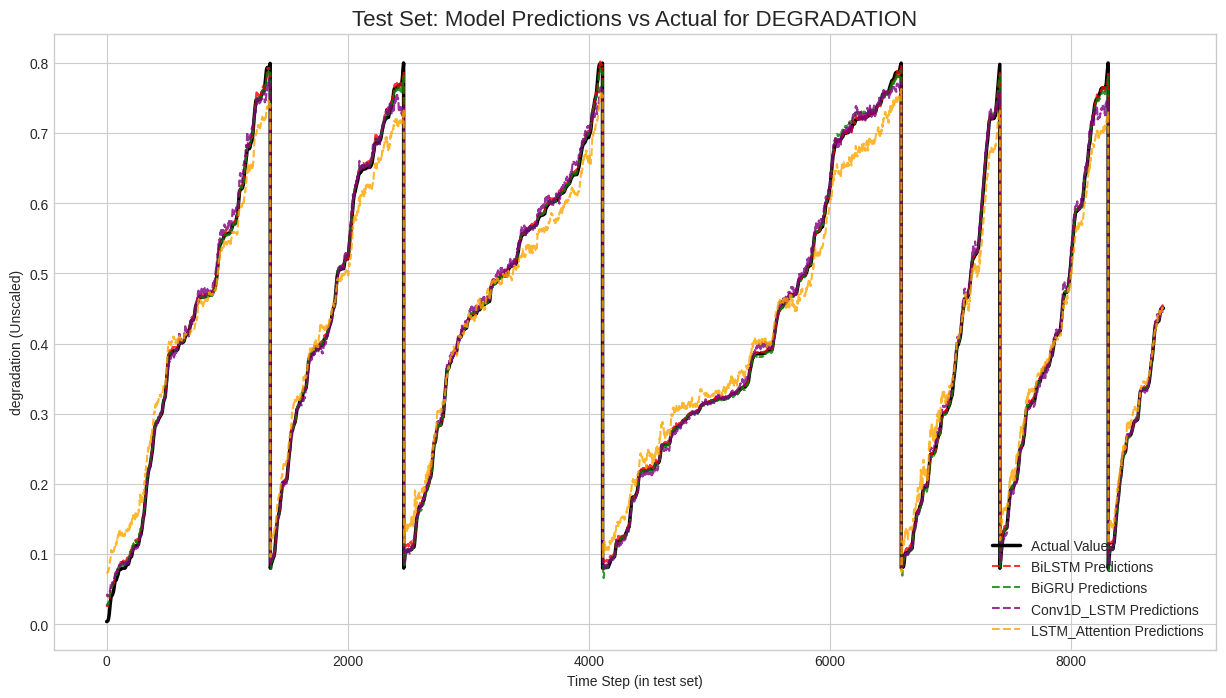

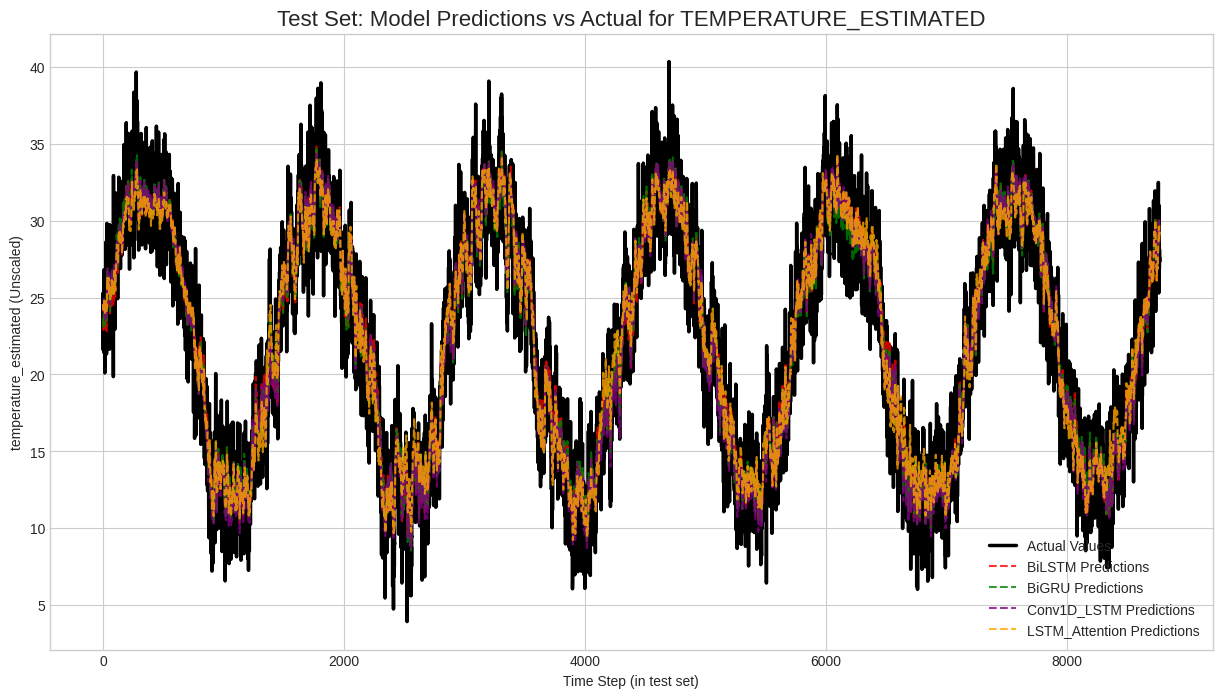

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



print("Plotting final comparison of all models on the test set...")


if 'all_results' not in locals() or 'actuals_unscaled' not in locals():
    print("Error: The 'all_results' or 'actuals_unscaled' variables were not found.")
    print("Please make sure you have successfully run the training cell first.")
else:
    
    target_columns = CONFIG.get("target_columns", ["target"])

 
    for i, target_name in enumerate(target_columns):
        plt.figure(figsize=(15, 8))

       
        plt.plot(actuals_unscaled[:, i], label='Actual Values', color='black', linewidth=2.5)

        
        colors = ['red', 'green', 'purple', 'orange']

       
        for j, (model_name, results) in enumerate(all_results.items()):
            
            if 'predictions' in results:
                
                plt.plot(results['predictions'][:, i], label=f'{model_name} Predictions', linestyle='--', alpha=0.8, color=colors[j % len(colors)])
            else:
                print(f"--> Warning: 'predictions' key not found for model '{model_name}'. Skipping plot for this model.")

        plt.title(f'Test Set: Model Predictions vs Actual for {target_name.upper()}', fontsize=16)
        plt.xlabel('Time Step (in test set)')
        plt.ylabel(f'{target_name} (Unscaled)')
        plt.legend()
        plt.grid(True)

        
        plt.show()